# AQI, Temperature, and Location

##### Links to all Kaggle Datasets, and API suppliers used
###### Air quality in Madrid - https://www.kaggle.com/datasets/decide-soluciones/air-quality-madrid
###### World AQI by City - https://www.kaggle.com/datasets/adityaramachandran27/world-air-quality-index-by-city-and-coordinates
###### Open-meteo API - https://open-meteo.com


In [4]:
# Import Libraries

import requests
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

## Finding a Correlation between AQ and Temperature in August of Madrid, 2001-2017

In [5]:
# Defining a function which makes an API call to retrieve temperature data for later use

def retrieveDailyMeanTemp(lat, long, start, end):
    response = requests.get(f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={long}&start_date={start}&end_date={end}&daily=temperature_2m_max&timezone=Europe%2FLondon")
    list1 = response.json()["daily"]["time"]
    list2 = response.json()["daily"]["temperature_2m_max"]
    df = pd.DataFrame(list(zip(list1, list2)), columns =['Date', 'Mean Temperature (Degrees Celsius)'])
    df["Date"] = pd.to_datetime(df["Date"])
    return df

### Visualising Madrid PM10 levels overtime

In [6]:
madrid_PM10_df = pd.read_csv("../datasheets/Madrid/Madrid_AVG_PM10_Levels.csv")
madrid_PM10_df.head()

,YEAR,AVG_PM10
0,2001,37.109608
1,2002,31.138318
2,2003,39.133485
3,2004,29.669498
4,2005,38.804536


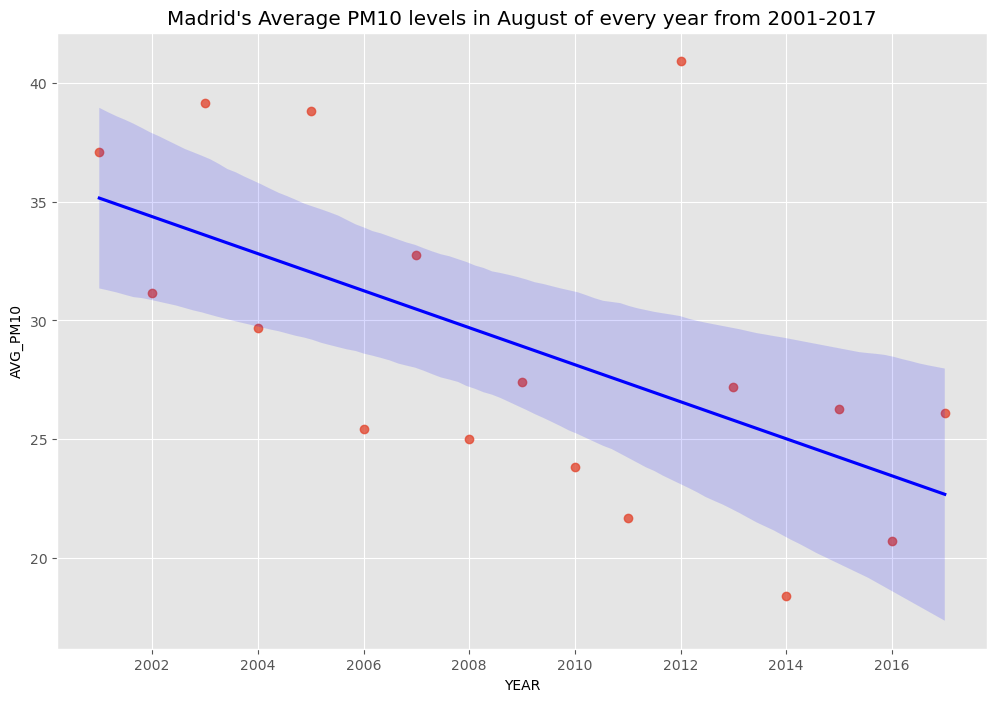

In [7]:
madrid_PM10VsTimeRegLine = sns.regplot(x="YEAR", y="AVG_PM10", data=madrid_PM10_df, line_kws={"color": "blue"}).set(title="Madrid's Average PM10 levels in August of every year from 2001-2017")

###### Average PM10 levels show a downward regression overtime in August of every year from 2001-2017, suggesting that overtime, AQ has increased.

### Visualising Madrid Temperature levels overtime

In [8]:
madrid_Temp_df = retrieveDailyMeanTemp("-3.75", "40.42", "2001-08-01", "2017-08-31")
madrid_Temp_df.head()

,Date,Mean Temperature (Degrees Celsius)
0,2001-08-01,24.5
1,2001-08-02,24.7
2,2001-08-03,24.4
3,2001-08-04,24.3
4,2001-08-05,24.5


In [9]:
madrid_Temp_df_AUG = madrid_Temp_df[(madrid_Temp_df["Date"].dt.month == 8)]
madrid_yearly_Temps = madrid_Temp_df_AUG.groupby(madrid_Temp_df_AUG["Date"].dt.year).mean(numeric_only=True)
madrid_yearly_Temps = madrid_yearly_Temps.reset_index()
madrid_yearly_Temps = madrid_yearly_Temps.rename(columns={"Date" : "Year"})
madrid_yearly_Temps.head()

,Year,Mean Temperature (Degrees Celsius)
0,2001,24.858065
1,2002,25.038710
2,2003,24.854839
3,2004,24.906452
4,2005,25.103226


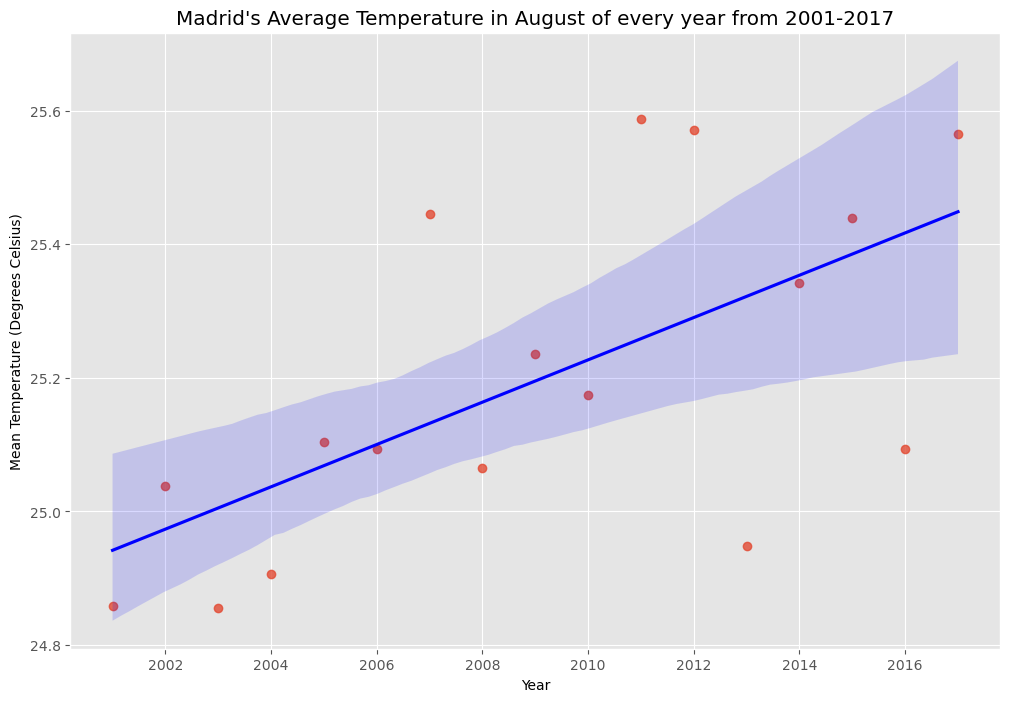

In [10]:
madrid_TempVsTimeRegLine = sns.regplot(x="Year", y="Mean Temperature (Degrees Celsius)", data=madrid_yearly_Temps, line_kws={"color": "blue"}).set(title="Madrid's Average Temperature in August of every year from 2001-2017")

###### Average Temp levels show an upward regression overtime in August of every year from 2001-2017, suggesting that overtime, Temperature has increased.

### Checking for a Relationship between Temperature and Air Quality

In [11]:
madrid_Temp_PM10 = pd.concat([madrid_yearly_Temps, madrid_PM10_df], axis=1)
madrid_Temp_PM10 = madrid_Temp_PM10.drop(["YEAR"], axis="columns")
madrid_Temp_PM10.head()

,Year,Mean Temperature (Degrees Celsius),AVG_PM10
0,2001,24.858065,37.109608
1,2002,25.038710,31.138318
2,2003,24.854839,39.133485
3,2004,24.906452,29.669498
4,2005,25.103226,38.804536


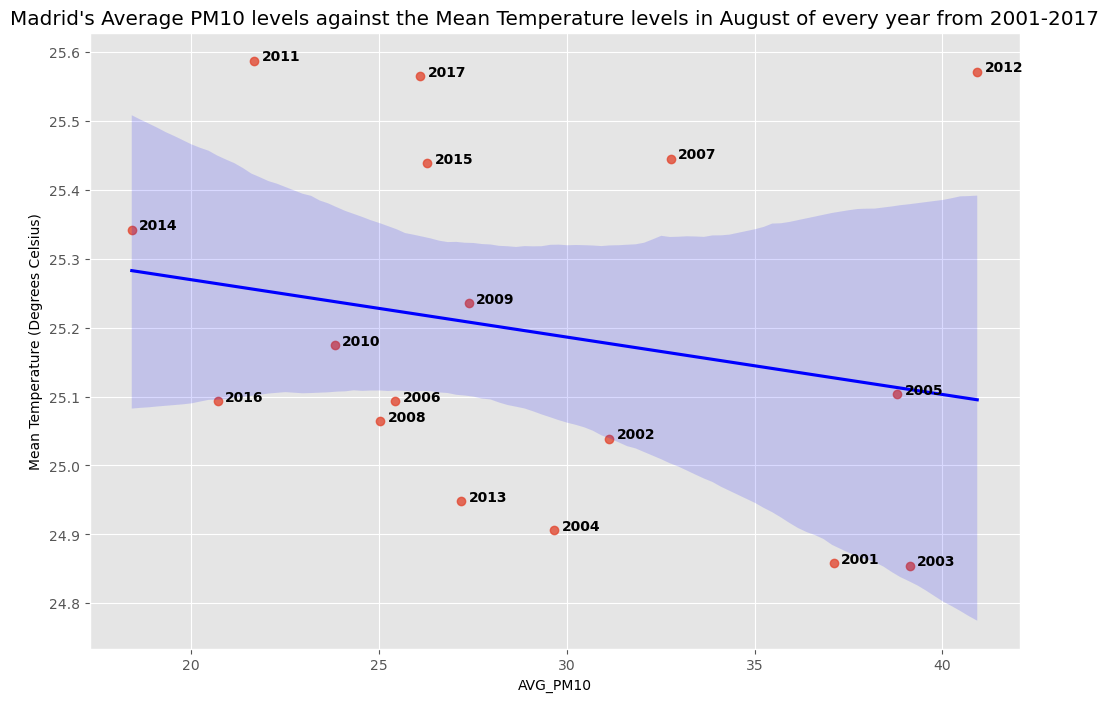

In [12]:
madrid_PM10VsTempRegLine = sns.regplot(x="AVG_PM10", y="Mean Temperature (Degrees Celsius)", data=madrid_Temp_PM10, line_kws={"color": "blue"}).set(title="Madrid's Average PM10 levels against the Mean Temperature levels in August of every year from 2001-2017")

for line in range(0, madrid_Temp_PM10.shape[0]):
     plt.text(madrid_Temp_PM10["AVG_PM10"][line]+0.2, 
              madrid_Temp_PM10["Mean Temperature (Degrees Celsius)"][line], 
              madrid_Temp_PM10["Year"][line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

###### There is not a very strong correlation between Average PM10 levels and Mean Temperature levels in August of every year from 2001-2017 in Madrid. However, there is a small downards regression, suggesting that when PM10 levels increase, temperature should decrease. This could, however be false, because correlation does not imply causation, and many other factors are involved, such as Madrid being relatively developed, allowing for the city to use technology that decreases the amount of air pollution, while still suffering from the affects of climate change. Therefore, these results cannot produce any significant colcusions. To draw a significant conclusion about the relationship between PM10 levels and Temperature, the two must be compared in isolation of other potential factors, and larger datasets, with data from a multitude of cities and countries, all with varying degrees of technological development, must be used.

## Looking at average air quality levels across the world

In [13]:
AQI_df = pd.read_csv("../datasheets/AQI_Desired_Columns.csv")
AQI_df.head()

,Country,City,AQI Value,AQI Category,lat,lng
0,Afghanistan,Kabul,64,Moderate,34.5253,69.1783
1,Afghanistan,Taywarah,62,Moderate,33.5100,64.4200
2,Afghanistan,Zaranj,133,Unhealthy for Sensitive Groups,30.9600,61.8600
3,Albania,Berat,91,Moderate,40.7000,19.9500
4,Albania,Burrel,113,Unhealthy for Sensitive Groups,41.6083,20.0111


### Modal AQI Categories in Cities Vs Countries

#### Cities

In [14]:
AQI_Category_City_Counts = AQI_df["AQI Category"].value_counts().to_frame().reset_index()
AQI_Category_City_Counts = AQI_Category_City_Counts.rename(columns={"AQI Category" : "Count"})
AQI_Category_City_Counts = AQI_Category_City_Counts.rename(columns={"index" : "AQI Category of Cities"})
AQI_Category_City_Counts.head()

,AQI Category of Cities,Count
0,Good,6497
1,Moderate,5788
2,Unhealthy,767
3,Unhealthy for Sensitive Groups,735
4,Very Unhealthy,120


<Axes: xlabel='AQI Category of Cities', ylabel='Count'>

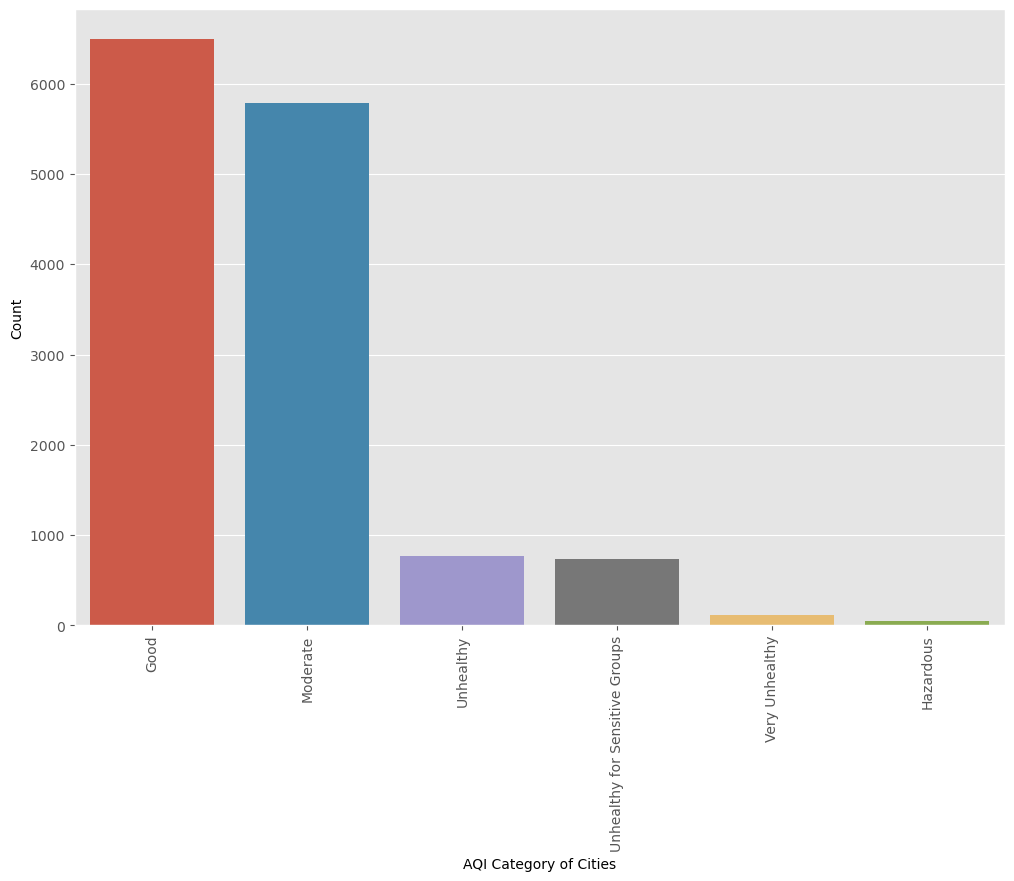

In [15]:
AQI_Category_City_Counts_Barplot = sns.barplot(data=AQI_Category_City_Counts, x="AQI Category of Cities", y="Count")
AQI_Category_City_Counts_Barplot.set_xticklabels(AQI_Category_City_Counts_Barplot.get_xticklabels(), rotation=90)
AQI_Category_City_Counts_Barplot

#### Countries

In [16]:
AQI_Category_Country = AQI_df.drop(["City", "AQI Value", "lat", "lng"], axis="columns")
AQI_Category_Country = AQI_Category_Country.groupby(["Country"])["AQI Category"].agg(pd.Series.mode).to_frame().reset_index()
AQI_Category_Country = AQI_Category_Country.rename(columns={"AQI Category" : "Modal AQI Category"})
AQI_Category_Country["Modal AQI Category"] = AQI_Category_Country["Modal AQI Category"].astype("string")
for x in AQI_Category_Country["Modal AQI Category"]:
    if "[" in x:
        a, b = x.split("' '")
        newCategory = b[:-2] + " - " + a[2:]
        AQI_Category_Country["Modal AQI Category"] = AQI_Category_Country["Modal AQI Category"].replace(x, newCategory)
AQI_Category_Country.head()

,Country,Modal AQI Category
0,Afghanistan,Moderate
1,Albania,Moderate
2,Algeria,Moderate
3,Andorra,Good
4,Angola,Good


In [17]:
AQI_Category_Country_Counts = AQI_Category_Country["Modal AQI Category"].value_counts().to_frame().reset_index()
AQI_Category_Country_Counts = AQI_Category_Country_Counts.rename(columns={"Modal AQI Category" : "Count"})
AQI_Category_Country_Counts = AQI_Category_Country_Counts.rename(columns={"index" : "Modal AQI Category of Countries"})
AQI_Category_Country_Counts.head()

,Modal AQI Category of Countries,Count
0,Moderate,75
1,Good,68
2,Unhealthy,13
3,Unhealthy for Sensitive Groups,9
4,Moderate - Good,5


<Axes: xlabel='Modal AQI Category of Countries', ylabel='Count'>

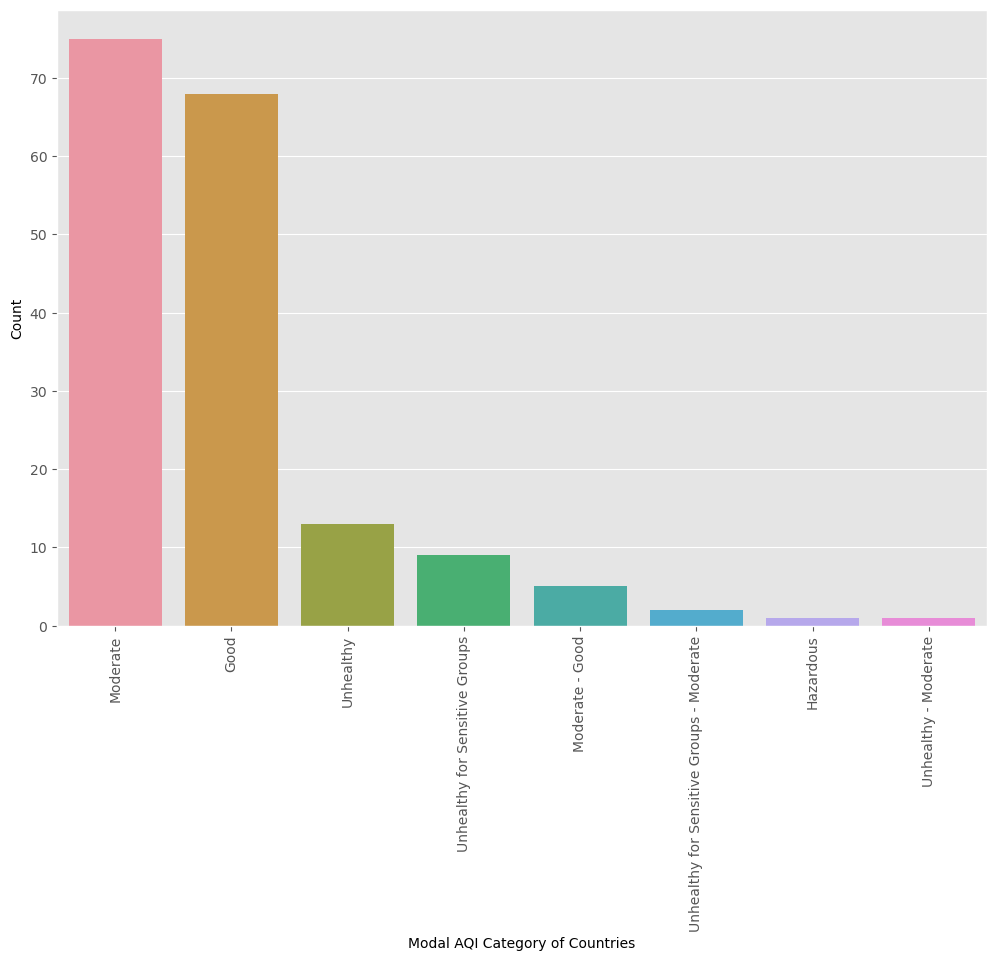

In [18]:
AQI_Category_Country_Counts_Barplot = sns.barplot(data=AQI_Category_Country_Counts, x="Modal AQI Category of Countries", y="Count")
AQI_Category_Country_Counts_Barplot.set_xticklabels(AQI_Category_Country_Counts_Barplot.get_xticklabels(), rotation=90)
AQI_Category_Country_Counts_Barplot

###### Most Cities have good AQI, while most Countries have a mode of Moderate AQI. This could be due to a multitude of reasons, such as countries only spending to increase Air Quality in the main cities, or main cities have lower Air Quality, however cities in the country for example tend to naturally have higher Air Quality. Air quality in major cities VS Air quality in other cities would need to be looked at in multiple different countries.

### AQI Vs Temperature

In [19]:
AQI_CITY_TEMP_COORDINATES = pd.read_csv("../datasheets/AQI_CITY_TEMP_COORDINATES.csv")
AQI_CITY_TEMP_COORDINATES.head()

,Unnamed: 0,Country,City,AQI Value,lat,lng,Mean Temperature (Degrees Celsius)
0,0,Afghanistan,Kabul,64,34.5253,69.1783,8.902500
1,1,Afghanistan,Taywarah,62,33.5100,64.4200,8.352500
2,2,Afghanistan,Zaranj,133,30.9600,61.8600,24.156667
3,3,Albania,Berat,91,40.7000,19.9500,14.052500
4,4,Albania,Burrel,113,41.6083,20.0111,12.476667


In [20]:
AQI_CITY_TEMP = AQI_CITY_TEMP_COORDINATES.drop(["lat", "lng", "Unnamed: 0"], axis="columns")
AQI_CITY_TEMP.head()

,Country,City,AQI Value,Mean Temperature (Degrees Celsius)
0,Afghanistan,Kabul,64,8.902500
1,Afghanistan,Taywarah,62,8.352500
2,Afghanistan,Zaranj,133,24.156667
3,Albania,Berat,91,14.052500
4,Albania,Burrel,113,12.476667


#### Removing Outliers (3 Standard Deviations away from the Mean)

In [21]:
AQI_CITY_TEMP.shape

(13956, 4)

In [22]:
AQI_mean = AQI_CITY_TEMP["AQI Value"].mean()
AQI_stdev = AQI_CITY_TEMP["AQI Value"].std()
Temp_mean = AQI_CITY_TEMP["Mean Temperature (Degrees Celsius)"].mean()
Temp_stdev = AQI_CITY_TEMP["Mean Temperature (Degrees Celsius)"].std()

AQI_CITY_TEMP_2 = AQI_CITY_TEMP[(AQI_CITY_TEMP["AQI Value"] > AQI_mean - (3*AQI_stdev)) & (AQI_CITY_TEMP["AQI Value"] < AQI_mean + (3*AQI_stdev)) & (AQI_CITY_TEMP["Mean Temperature (Degrees Celsius)"] > Temp_mean - (3*Temp_stdev)) & (AQI_CITY_TEMP["Mean Temperature (Degrees Celsius)"] < Temp_mean + (3*Temp_stdev))]
AQI_CITY_TEMP_2.shape

(13740, 4)

#### Plotting AQI against Temperature

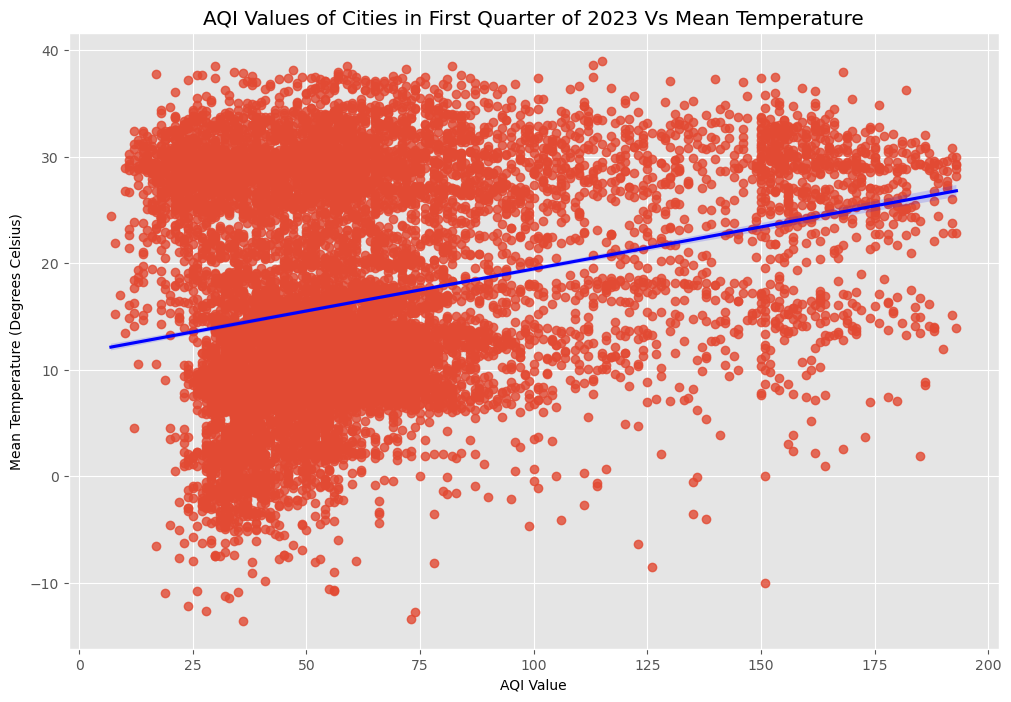

In [23]:
AQI_Vs_Temp = sns.regplot(data=AQI_CITY_TEMP_2, x="AQI Value", y="Mean Temperature (Degrees Celsius)", line_kws={"color": "blue"}).set(title="AQI Values of Cities in First Quarter of 2023 Vs Mean Temperature")

###### According to the Regression Plot, as AQI Value increases, so does Mean Temperature, however this correlation is a very weak correlation as shown above, and although there are fewer points with higher AQI Values that show lower Mean Temperatures, there are still many of these points. Moreover, there is a large spread of cities with low AQI Values that also have high mean temperatures. Overall, this data suggests that mean temperature is determined more by location and less by AQI value. Meaning the effect of AQI Values on temperature can only be deduced after having measured the two variables over periods of time in the same location each time, where there are no other variables at play such as technological advancements in terms of cleaning air.

### Looking at Mean AQI values and Mean Temperatures of Countries

In [24]:
AQI_COUNTRY_TEMP = AQI_CITY_TEMP_2.drop(["City"], axis="columns").groupby(["Country"]).mean().reset_index()
AQI_COUNTRY_TEMP.head()

,Country,AQI Value,Mean Temperature (Degrees Celsius)
0,Afghanistan,86.333333,13.803889
1,Albania,77.111111,12.958426
2,Algeria,106.250000,19.690417
3,Andorra,32.000000,9.688333
4,Angola,68.526316,27.162237


#### Looking at AQI Vs Temp in All Countries

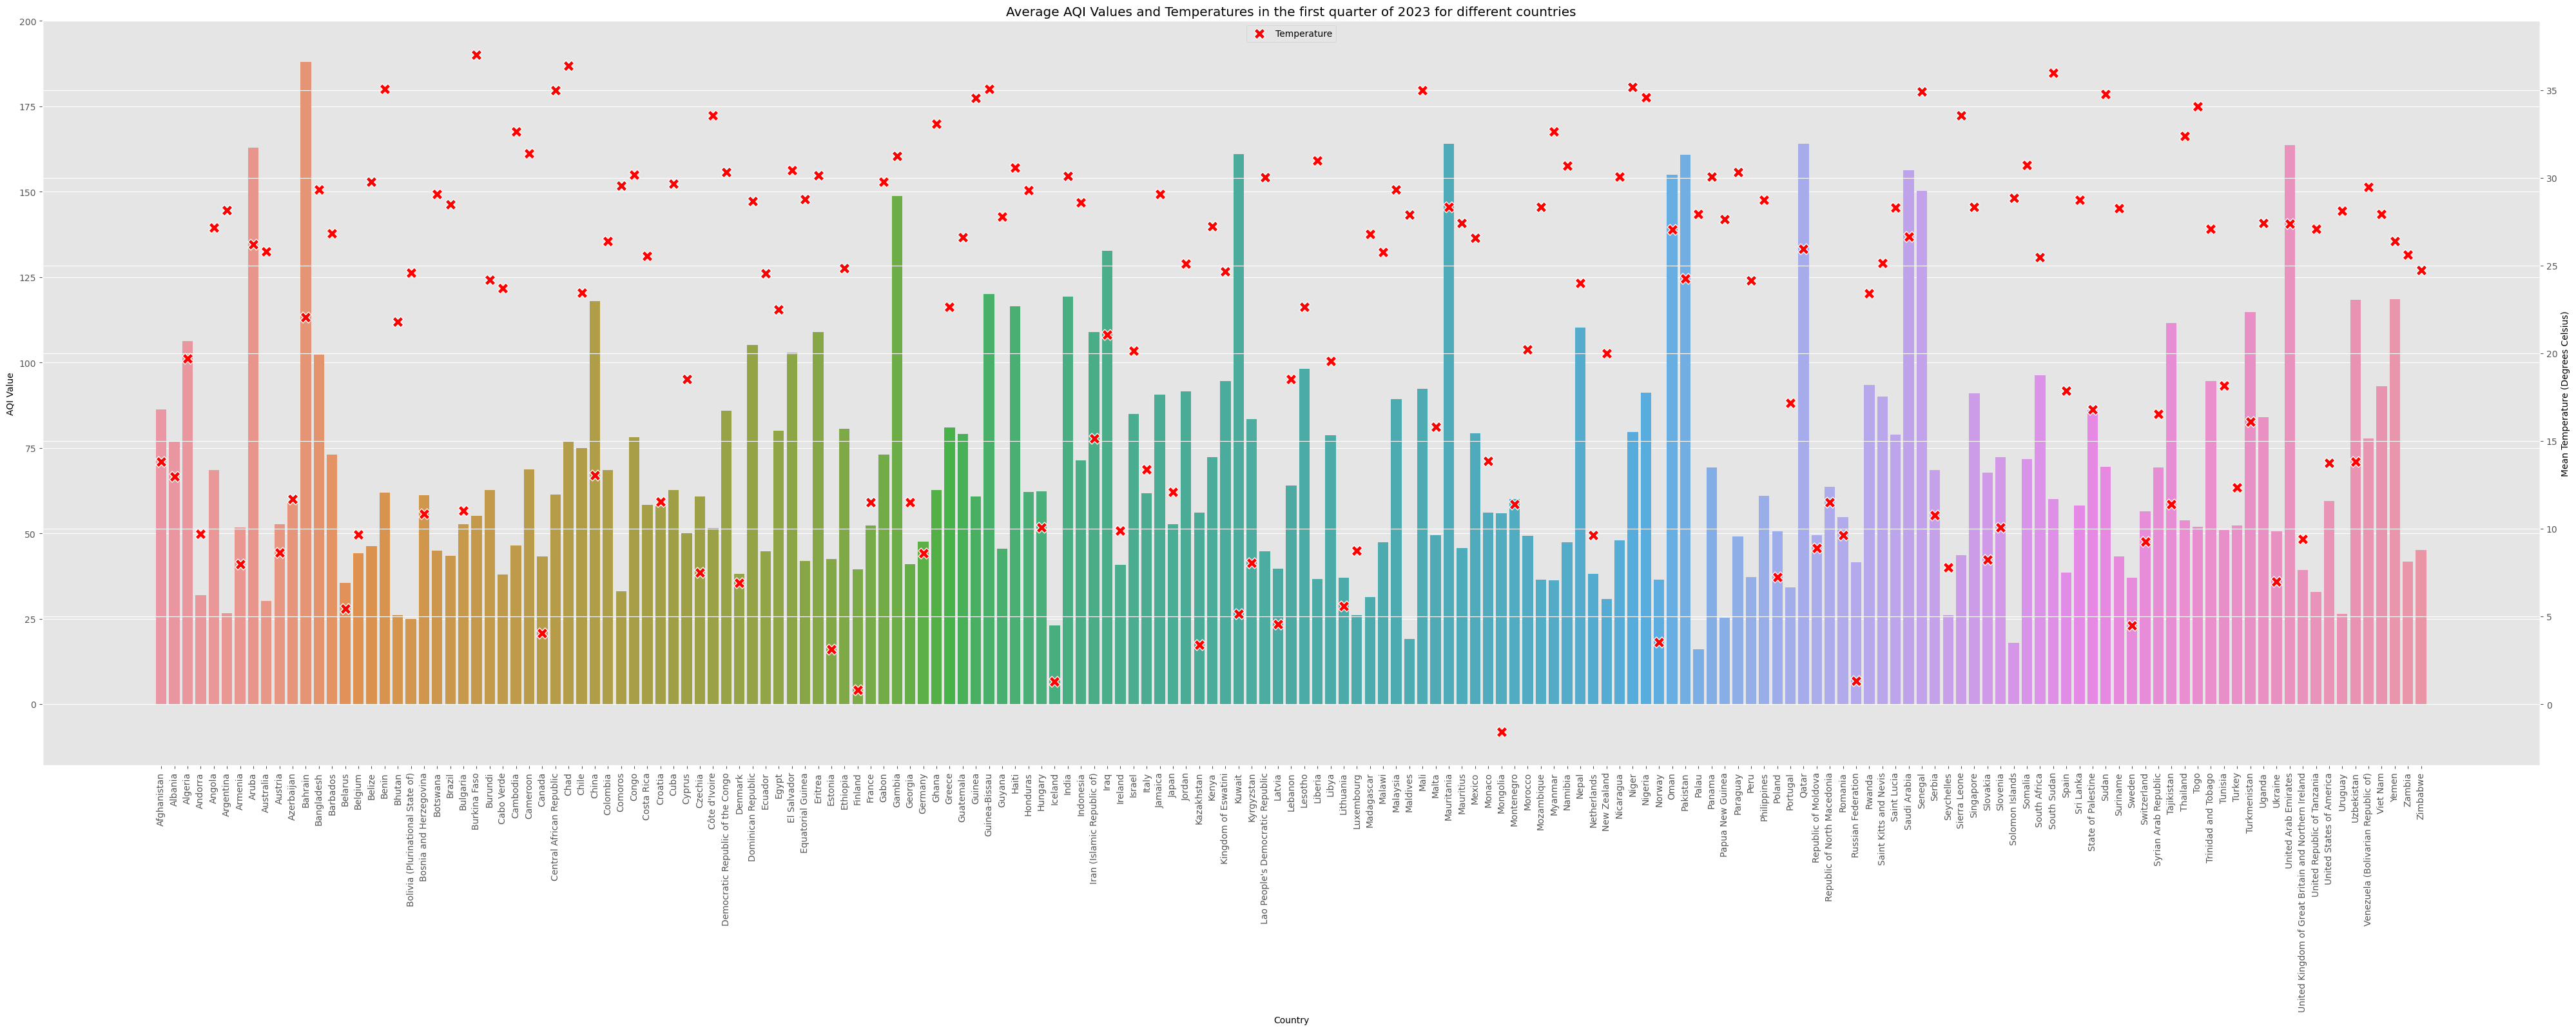

In [25]:
plt.figure(figsize=(50, 15))
Country_Vs_AQI = sns.barplot(data=AQI_COUNTRY_TEMP, x="Country", y="AQI Value")
Country_Vs_AQI.set_xticklabels(Country_Vs_AQI.get_xticklabels(), rotation=90)
Country_Vs_AQI.set(ylim=(-18, 200))
ax2 = Country_Vs_AQI.twinx()
Country_Vs_AQI_Temp = sns.scatterplot(data=AQI_COUNTRY_TEMP, x="Country", y="Mean Temperature (Degrees Celsius)", ax=ax2, color="red", s=150, marker="X")
Country_Vs_AQI_Temp.set(title="Average AQI Values and Temperatures in the first quarter of 2023 for different countries")
Country_Vs_AQI_Temp.legend(labels=["Temperature"], loc = 9)

#### Looking at AQI Vs Temp in Countries with Low AQI (AQI falls below the First Quartile)

In [26]:
AQI_median = AQI_COUNTRY_TEMP["AQI Value"].median()
AQI_Q1 = AQI_COUNTRY_TEMP["AQI Value"].quantile(0.25)
AQI_Q3 = AQI_COUNTRY_TEMP["AQI Value"].quantile(0.75)
AQI_COUNTRY_TEMP.shape

(173, 3)

In [27]:
LOW_AQI_COUNTRY_TEMP = AQI_COUNTRY_TEMP[AQI_COUNTRY_TEMP["AQI Value"] < AQI_Q1]
LOW_AQI_COUNTRY_TEMP.shape

(43, 3)

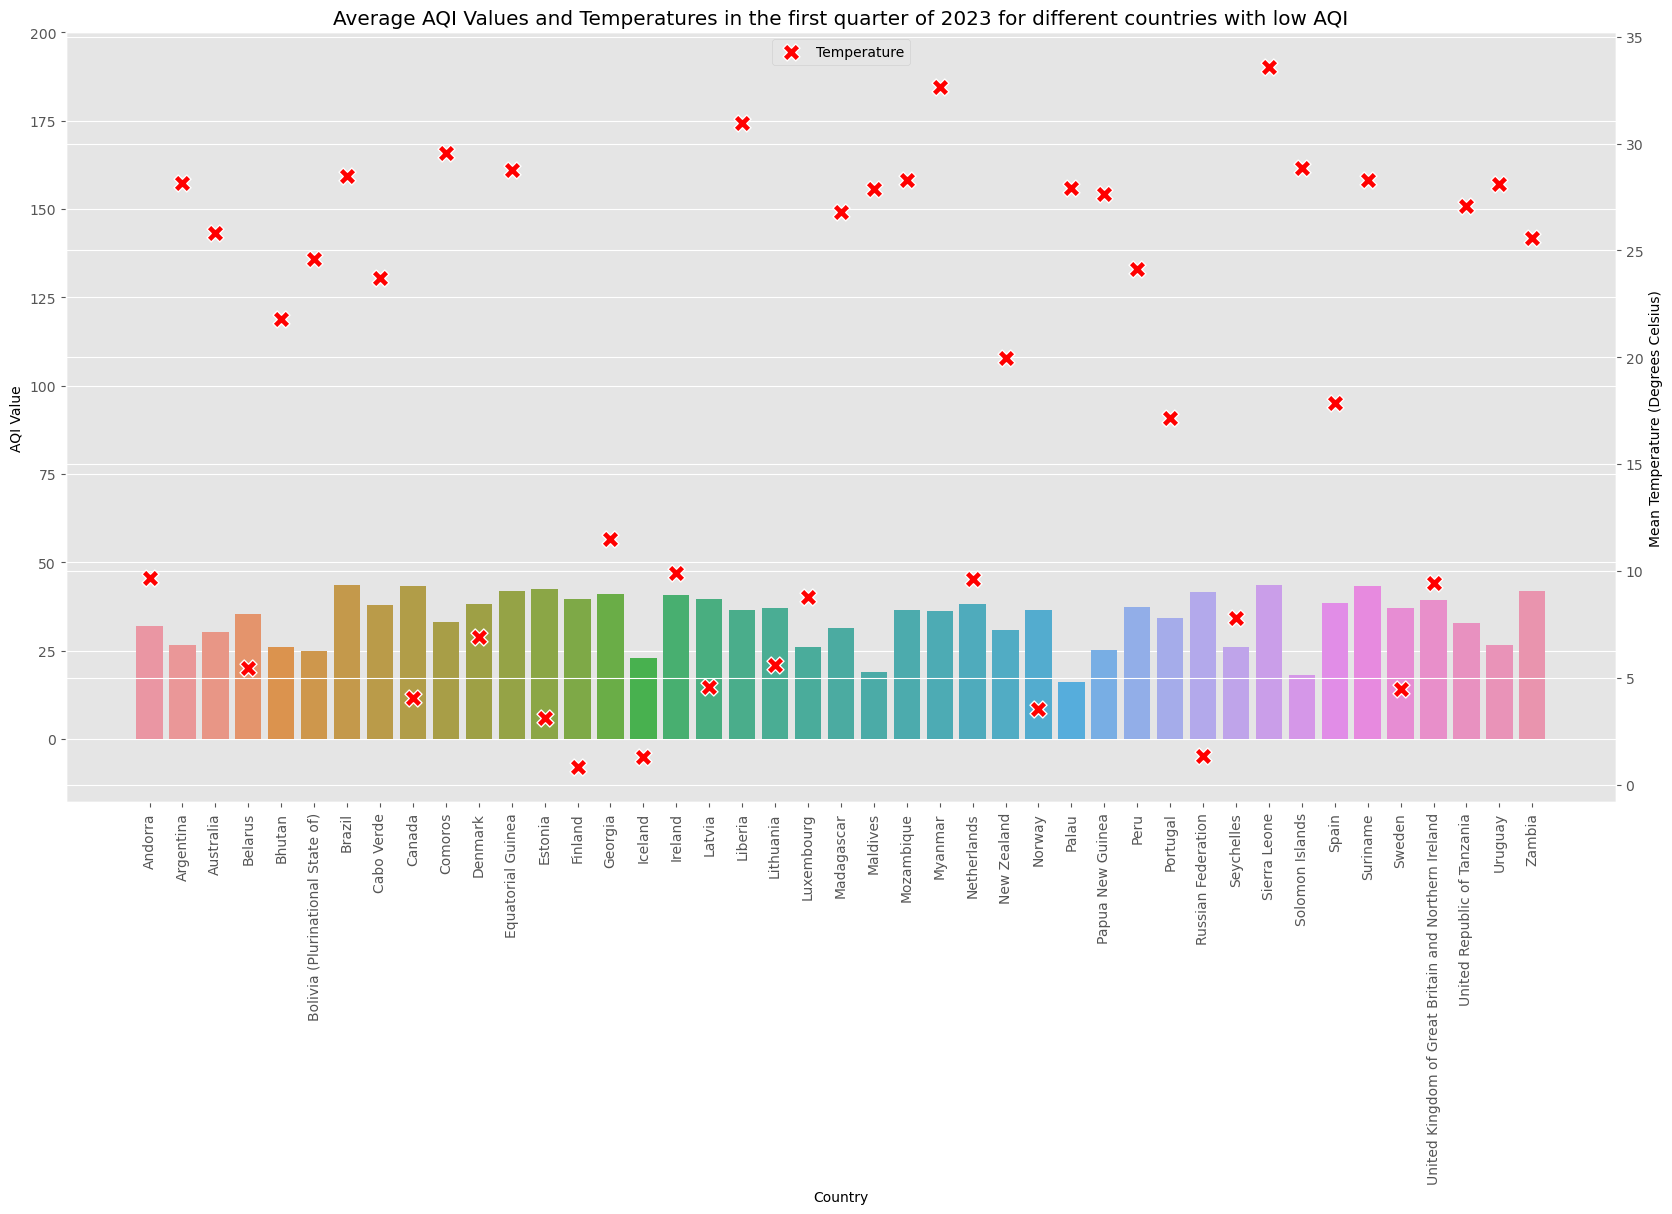

In [28]:
plt.figure(figsize=(20, 10))
Country_Vs_LowAQI = sns.barplot(data=LOW_AQI_COUNTRY_TEMP, x="Country", y="AQI Value")
Country_Vs_LowAQI.set_xticklabels(Country_Vs_LowAQI.get_xticklabels(), rotation=90)
Country_Vs_LowAQI.set(ylim=(-18, 200))
ax2 = Country_Vs_LowAQI.twinx()
Country_Vs_LowAQI_Temp = sns.scatterplot(data=LOW_AQI_COUNTRY_TEMP, x="Country", y="Mean Temperature (Degrees Celsius)", ax=ax2, color="red", s=150, marker="X")
Country_Vs_LowAQI_Temp.set(title="Average AQI Values and Temperatures in the first quarter of 2023 for different countries with low AQI")
Country_Vs_LowAQI_Temp.legend(labels=["Temperature"], loc = 9)

###### Countries with Low AQI tend to be more developed countries, these countries tend not to have a moderate temperature but instead are either fairly low or fairly high. However there are exceptions to this rule, such as Spain, which has moderate temperature but a low AQI. There are also least developed countries present in the low AQI group such as Liberia.

#### Looking at AQI Vs Temp in Countries with Average AQI (AQI falls in the IQR)

In [29]:
MED_AQI_COUNTRY_TEMP = AQI_COUNTRY_TEMP[(AQI_COUNTRY_TEMP["AQI Value"] > AQI_Q1) & (AQI_COUNTRY_TEMP["AQI Value"] < AQI_Q3)]
MED_AQI_COUNTRY_TEMP.shape

(85, 3)

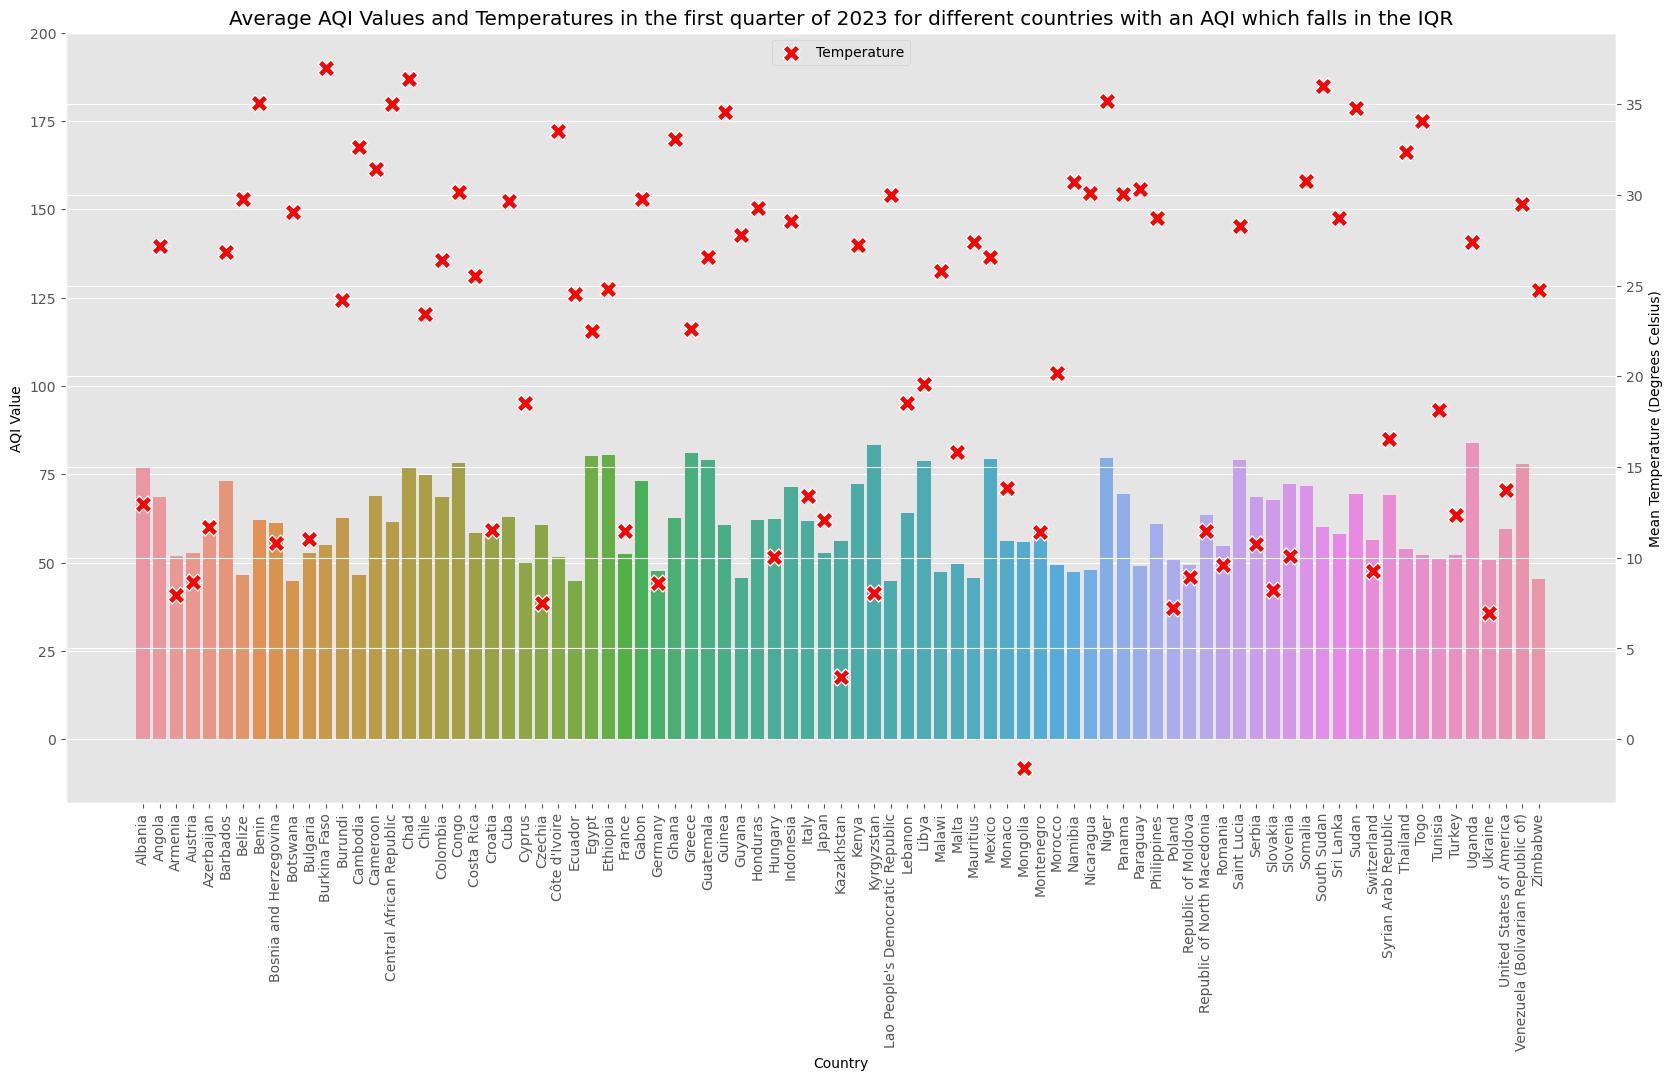

In [30]:
plt.figure(figsize=(20, 10))
Country_Vs_MedAQI = sns.barplot(data=MED_AQI_COUNTRY_TEMP, x="Country", y="AQI Value")
Country_Vs_MedAQI.set_xticklabels(Country_Vs_MedAQI.get_xticklabels(), rotation=90)
Country_Vs_MedAQI.set(ylim=(-18, 200))
ax2 = Country_Vs_MedAQI.twinx()
Country_Vs_MedAQI_Temp = sns.scatterplot(data=MED_AQI_COUNTRY_TEMP, x="Country", y="Mean Temperature (Degrees Celsius)", ax=ax2, color="red", s=150, marker="X")
Country_Vs_MedAQI_Temp.set(title="Average AQI Values and Temperatures in the first quarter of 2023 for different countries with an AQI which falls in the IQR")
Country_Vs_MedAQI_Temp.legend(labels=["Temperature"], loc = 9)

###### Countries with a relatively normal AQI show a wide spread in terms of their temperatures and levels of development, for example, there is South Sudan which is a less developed country with a high temperature that has a moderate AQI, and there is Italy, which is much more cooler, more developed, and has a similar AQI to South Sudan.

#### Looking at AQI Vs Temp in Countries with High AQI (AQI above the Third Quartile)

In [31]:
HIGH_AQI_COUNTRY_TEMP = AQI_COUNTRY_TEMP[AQI_COUNTRY_TEMP["AQI Value"] > AQI_Q3]
HIGH_AQI_COUNTRY_TEMP.shape

(43, 3)

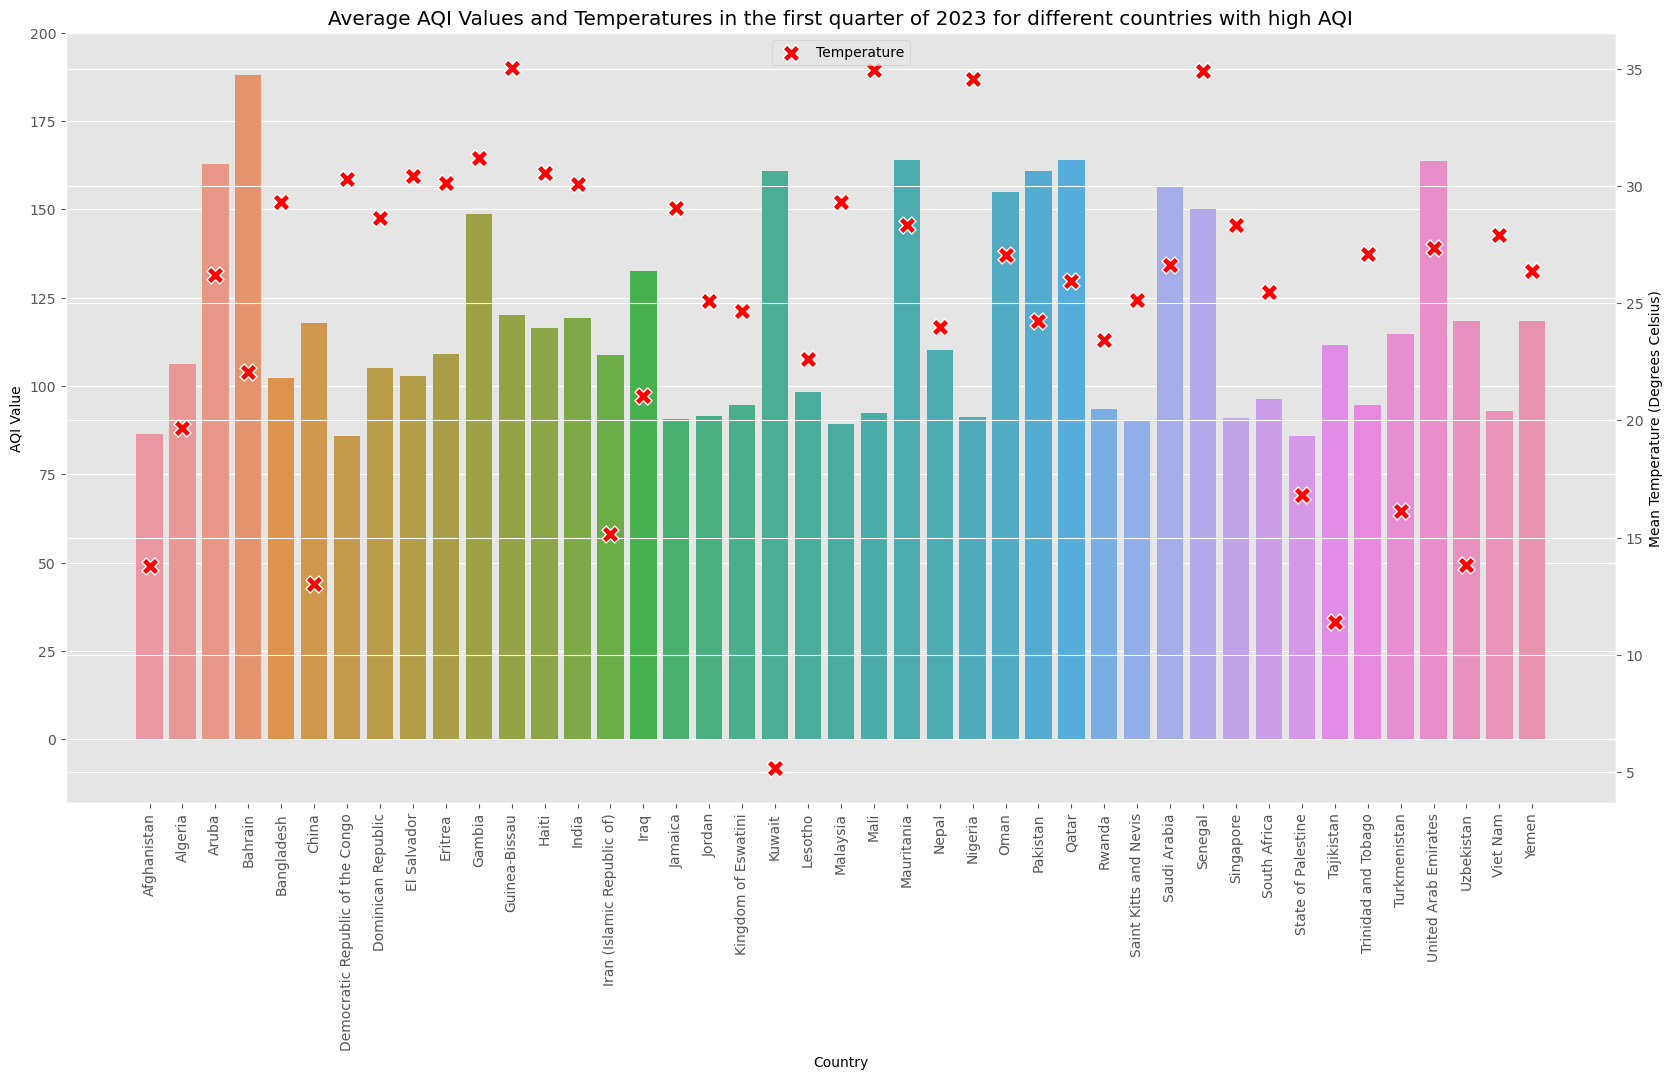

In [32]:
plt.figure(figsize=(20, 10))
Country_Vs_HighAQI = sns.barplot(data=HIGH_AQI_COUNTRY_TEMP, x="Country", y="AQI Value")
Country_Vs_HighAQI.set_xticklabels(Country_Vs_HighAQI.get_xticklabels(), rotation=90)
Country_Vs_HighAQI.set(ylim=(-18, 200))
ax2 = Country_Vs_HighAQI.twinx()
Country_Vs_HighAQI_Temp = sns.scatterplot(data=HIGH_AQI_COUNTRY_TEMP, x="Country", y="Mean Temperature (Degrees Celsius)", ax=ax2, color="red", s=150, marker="X")
Country_Vs_HighAQI_Temp.set(title="Average AQI Values and Temperatures in the first quarter of 2023 for different countries with high AQI")
Country_Vs_HighAQI_Temp.legend(labels=["Temperature"], loc = 9)

###### Countries with High AQI tend to be less developed countries, most of which are countries with high temperatures. However there are exceptions to this rule, such as China, which is a highly developed country with a low temperature but high AQI.

### Conclusions about AQI, Temperature and Location

###### Since more research needs to be done in both a controlled and uncontrolled environment on the effect of AQI on Temperature and vice versa, the relationship between the two remains inconclusive with the current information at hand. However, AQI and location does seem to have a relationship, where more developed countries, such as Spain and Finland, tend to have lower or moderate AQIs (The lower the AQI the better the Air Quality). The opposite is true for lesser developed countries, such as Bangladesh and Yemen. This information suggests that location does play a role in the levels of Air Quality, but not specifically because of the location of the land, more because of the land's economic advantages. However, there are many exceptions to this, such as Sierra Leone being an incredibly hot and also poor country, but shows a low AQI, while Qatar, a country that also has a high temperature has a high AQI despite being highly developed. This could potentially occur if Qatar would choose not to spend on technological advancements to increase Air Quality, however there is no data on that information here so those speculations remain as inconclusive.